### Modis Download and Processing
Script designed to process Modis images and save them one by one.

1. Find vtiles/htiles/dates for each data point
2. define windows around them, cut image
3. save images 

Potentially intended to offload eventually to azure vms

In [106]:
import pandas as pd
import geojson as gsn
from pyproj import Proj
from osgeo import gdal
from osgeo import gdalconst

import tempfile
import wget
import math
import numpy as np
import matplotlib.pyplot as plt
import os

from collections import defaultdict
from datetime import datetime, timedelta

import xarray as xr
import rioxarray as rxr
from azure.storage.blob import ContainerClient

modis_account_name = 'modissa'
modis_container_name = 'modis-006'
modis_account_url = 'https://' + modis_account_name + '.blob.core.windows.net/'
modis_blob_root = modis_account_url + modis_container_name + '/'

# This file is provided by NASA; it indicates the lat/lon extents of each
# NOTE: this was from tutorial, not actually helpful because unprojected?

modis_tile_extents_url = modis_blob_root + 'sn_bound_10deg.txt'

temp_dir = os.path.join(tempfile.gettempdir(),'modis')
os.makedirs(temp_dir,exist_ok=True)
fn = os.path.join(temp_dir,modis_tile_extents_url.split('/')[-1])
# wget.download(modis_tile_extents_url, fn)


modis_container_client = ContainerClient(account_url=modis_account_url, 
                                         container_name=modis_container_name,
                                                  credential=None)

### see above TODO


In [2]:
def lat_lon_to_modis_tile(lat,lon):
    '''converts lat lon to modis tiles but reconstructing grid and its projection'''
    
    CELLS = 2400
    VERTICAL_TILES = 18
    HORIZONTAL_TILES = 36
    EARTH_RADIUS = 6371007.181
    EARTH_WIDTH = 2 * math.pi * EARTH_RADIUS

    TILE_WIDTH = EARTH_WIDTH / HORIZONTAL_TILES
    TILE_HEIGHT = TILE_WIDTH
    CELL_SIZE = TILE_WIDTH / CELLS
    
    MODIS_GRID = Proj(f'+proj=sinu +R={EARTH_RADIUS} +nadgrids=@null +wktext')
    
    x, y = MODIS_GRID(lon, lat)
    h = (EARTH_WIDTH * .5 + x) / TILE_WIDTH
    v = -(EARTH_WIDTH * .25 + y - (VERTICAL_TILES - 0) * TILE_HEIGHT) / TILE_HEIGHT
    
    return int(h), int(v)


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_hdf_blobs_in_folder(container_name,folder_name):
    """"
    List .hdf files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.hdf')]
    return files

Ingest training + testing geodata and timestamps

Note: paths are currently absolute, but happy to make them work on both machines

In [3]:
path = "C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/grid_cells.geojson"
with open(path) as f:
    gj = gsn.load(f)
print(len(gj['features']))

18130


Estimate centroids for lat_lon calculations by taking mean of points (not actual centroid because of projection and great circle distance?)

In [4]:
centroids = {} #cellid : centroid

for cell in range(len(gj['features'])):
    assert len(gj['features'][cell]['geometry']['coordinates'][0]) == 5 #coordinates have repeat on fifth, make sure this is universal
    
    cell_id =gj['features'][cell]['properties']['cell_id']
    centroid = list(np.mean(
        gj['features'][cell]['geometry']['coordinates'][0][0:4],
        axis = 0)) #lazy centroid calculation
    centroids[cell_id] = centroid

1. Ingest training, testing, submission datasets
2. Find what tiles (time, h,v) each image are stored in
3. store by cell_id, recall later for centroids

In [5]:
train_feat = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_train_features.csv")
test =pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_test_features.csv")
submission = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/submission_format.csv")
train_y = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/train_labels.csv")

In [6]:
#grab date/cell_id combos
dates = {}

#go through all rows, grab nonnull dates
for i in range(train_y.shape[0]):
    dates[train_y.iloc[i,0]] =list(
        train_y.iloc[i,1:][~train_y.iloc[i,:].isnull()].index)#cell_id : [dates]


Compile overlapping tiles

In [7]:
# create dictionary tiles (date, lat, lon) : [cell_ids]
counter = 0 
tiles = defaultdict(list)
for cell, date_list in dates.items():
    for date in date_list:
        
        modis_tile = lat_lon_to_modis_tile(centroids[cell][1], centroids[cell][0])
        tiles[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter += 1
print("total squares:", counter)    

total squares: 91490


## Download relevant images

Process and save smaller images one by one

In [35]:
# daynum = '2014236'
def daynum_gen(date_time):
    '''converts date time objects to filename'''
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

In [32]:
folder

'MCD43A4/08/04/201541'

In [68]:
product = 'MCD43A4'

# test_tuple = list(tiles)[100]
test_tuple= list(tiles)[0]
date = test_tuple[0]
daynum = daynum_gen(date)   
tile_num = (test_tuple[1],test_tuple[2])

folder = product + '/' + '{:0>2d}/{:0>2d}'.format(test_tuple[1],test_tuple[2]) + '/' + daynum

In [69]:
# Find all HDF files from this tile on this day
filenames = list_hdf_blobs_in_folder(modis_container_name,folder)
print('Found {} matching file(s):'.format(len(filenames)))
for fn in filenames:
    print(fn)
file_root = filenames.copy()
    
# Work with the first returned URL
file_found = False
while not file_found:
    try:
        blob_name = filenames[0]
        file_found = True
    except IndexError:
        print("No file found: tile {} date {}".format(tile_num,daynum))
        date -= timedelta(days=1)
        daynum = daynum_gen(date) 
        print("trying:", daynum)

    
# Download to a temporary file
url = modis_blob_root + blob_name

filename = os.path.join(temp_dir,blob_name.replace('/','_'))
if not os.path.isfile(filename):
    wget.download(url,filename)

Found 1 matching file(s):
MCD43A4/08/05/2018116/MCD43A4.A2018116.h08v05.006.2018125031956.hdf


### Reproject and Process images

From SR-ORG:6974 to EPSG:4326

In [92]:
gdal.UseExceptions()
outf = "C:/Users/Matt/Dropbox/SnowComp/"+blob_name.replace('/','_')[:-4] +'_%d.tif'

src_crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

sds = gdal.Open(filename, gdalconst.GA_ReadOnly).GetSubDatasets()
for i in range(len(sds)):
    gdal.Warp(outf % i, sds[i][0],srcSRS = src_crs, dstSRS='EPSG:4326')

In [410]:
# src_crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
# gdal.Warp("~/TestWarp",filename, srcSRS = src_crs,dstSRS="EPSG:4326")

RuntimeError: Input file C:\Users\Matt\AppData\Local\Temp\modis\MCD43A4_08_05_2018116_MCD43A4.A2018116.h08v05.006.2018125031956.hdf has no raster bands.

In [93]:
assert len(file_root) == 1 # future images may come in multiples, not currently handled
test_im = "C:/Users/Matt/Dropbox/SnowComp/MCD43A4_08_05_2018116_MCD43A4.A2018116.h08v05.006.2018125031956_0.tif"
image = rxr.open_rasterio(test_im)
# image = rxr.open_rasterio(filename)

# output_raster = "C:/Users/Matt/Pictures/"+file_root[0] + "-epsg4326"+".hdf"
# file_root[0] = file_root[0].replace('.', '-').replace('/','-')


# image = rds.rio.reproject(dst_crs="EPSG:4326",src_crs=src_crs) # .rio.to_raster(output_raster)
image

<xarray.DataArray (band: 1, y: 1194, x: 3177)>
[3793338 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -130.5 -130.5 -130.5 ... -103.9 -103.9 -103.9
  * y            (y) float64 40.0 39.99 39.98 39.97 ... 30.03 30.02 30.01 30.0
    spatial_ref  int32 0
Attributes:
    _FillValue:    255.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     BRDF_Albedo_Band_Mandatory_Quality_Band1
    units:         concatenated flags

Create blocks around centroids

In [94]:
cells = tiles[test_tuple]
# for cell in cells:
test_cell = cells[0]

center = centroids[test_cell]



In [113]:
x_idx = np.nanargmin(np.abs(image.x.values - center[0]))
y_idx = np.nanargmin(np.abs(image.y.values - center[1]))

#subset 21x21 square
xmin, xmax = x_idx -10 , x_idx + 11 
ymin, ymax = y_idx -10 , y_idx + 11


In [96]:
ymin

1183

In [97]:
image[dict(x= slice(xmin,xmax), y= slice(ymin,ymax))]

<xarray.DataArray (band: 1, y: 11, x: 21)>
array([[[255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255],
        ...,
        [255, 255, ..., 255, 255],
        [255, 255, ..., 255, 255]]], dtype=uint8)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -118.8 -118.8 -118.8 ... -118.7 -118.6 -118.6
  * y            (y) float64 30.09 30.08 30.07 30.06 ... 30.03 30.02 30.01 30.0
    spatial_ref  int32 0
Attributes:
    _FillValue:    255.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     BRDF_Albedo_Band_Mandatory_Quality_Band1
    units:         concatenated flags

### Sanity check of image

In [101]:
print(next(iter(centroids.items())))
print("min:",image.x.min().values,"max:",image.x.max().values)
print("min:",image.y.min().values,"max:",image.y.max().values)

('0003f387-71c4-48f6-b2b0-d853bd4f0aba', [-118.7234445, 37.0777755])
min: -130.5365401686838 max: -103.92962580923101
min: 30.001463381799127 max: 39.99581125044749


In [100]:
print(image.y.values[y_idx])
print(image.x.values[x_idx])

30.001463381799127
-118.72427655192422


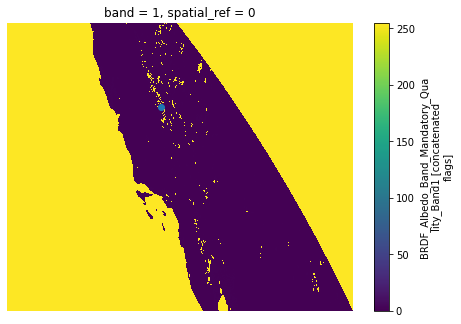

In [114]:
# ds = rxr.open_rasterio(output_raster)

# norm_value = 5000
# r = image['Nadir_Reflectance_Band1'].values.squeeze() / norm_value
# g = image['Nadir_Reflectance_Band4'].values.squeeze() / norm_value
# b = image['Nadir_Reflectance_Band3'].values.squeeze() / norm_value
# rgb = np.dstack((r,g,b))

# np.clip(rgb,0,1,rgb)
fig = plt.figure(frameon=False); ax = plt.Axes(fig,[0., 0., 1., 1.])
ax.set_axis_off(); fig.add_axes(ax)
image.squeeze().plot.imshow(ax=ax)
# xr.plot.imshow(image.squeeze())


plt.scatter(x = image.x.values[x_idx],y = image.y.values[y_idx])